# Data PreProcessing

In [23]:
import sys
sys.path.append('/Users/mac/Desktop/Desktop_Files/Projects/Zomato Restaurant Rating Prediction')


In [118]:
# Prevent WARNINGS!
import warnings
warnings.filterwarnings('ignore')

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from utility.utils import analyze_corr, convert_cat
import scipy.stats as stats
from scipy.stats import zscore


In [16]:
## laoding the dataset (EDA_final_cleaned.pkl)
import joblib
df = joblib.load("../artifacts/EDA_final_cleaned.pkl")

In [17]:
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city,rating_group,cuisines_list
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,1,1,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3 to 4.2,"[North Indian, Mughlai, Chinese]"
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,1,0,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,3 to 4.2,"[Chinese, North Indian, Thai]"


#### Categorical Conversion

In [18]:
## dropping cuisine column as it is not categorical->
df = df.drop(columns=['cuisines'], axis=1)

Note-> The dtype will still be int because we are also puttin integer codes for those categoricla columns 
- u can check the utils.py file having convert_cat fucntion with .cat.codes feature in it.

In [19]:
## converting  columns to category dtype
col_list = ['online_order', 'book_table', 'location', 'rest_type', 'type', 'city']
df = convert_cat(df, col_list)


In [20]:
df[col_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41665 entries, 0 to 41664
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   online_order  41665 non-null  int8 
 1   book_table    41665 non-null  int8 
 2   location      41665 non-null  int8 
 3   rest_type     41665 non-null  int8 
 4   type          41665 non-null  int8 
 5   city          41665 non-null  int8 
dtypes: int8(6)
memory usage: 244.3 KB


In [80]:
df['approx_cost'].sample(5)

22601    350
38660    300
19545    350
23192    400
22445    200
Name: approx_cost, dtype: int64

### Outliers Detection->

In [ ]:
## Function to check for outliers using IQR method
def check_outliers(df, col):
    s = df[col]   ## selecting the series (column)

    # calculatin both quartiles
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1

    # bounds
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    # Vectorized checks for outliers
    has_lower = (s < lower_bound).any()
    has_upper = (s > upper_bound).any()

    # Print summary
    print(f"IQR: {iqr}")
    print(f"Lower cutoff: {lower_bound}")
    print(f"Upper cutoff: {upper_bound}\n")

    print("Lower Side:", "Outliers present 🚩" if has_lower else "No outliers ✅")
    print("Upper Side:", "Outliers present 🚩" if has_upper else "No outliers ✅")




In [149]:
check_outliers(df, 'approx_cost')

IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅


- Fortunately, our data has no outliers for "approx_cost" column

Let's check for all other columns->

In [147]:
#df.head(2)

In [145]:
# online_order 
# check_outliers(df, 'online_order' ) # obv no outliers bcz categorical

In [146]:
## check_outliers(df, 'rate' )

### Outlier Detection in DataFrame Columns->

In [106]:
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        print(f"Checking outliers for column: {col}")
        check_outliers(df, col)
        print("-" * 40)

Checking outliers for column: rate
IQR: 0.6000000000000001
Lower cutoff: 2.5
Upper cutoff: 4.9

Lower Side: Outliers present 🚩
Upper Side: No outliers ✅
----------------------------------------
Checking outliers for column: votes
IQR: 255.0
Lower cutoff: -361.5
Upper cutoff: 658.5

Lower Side: No outliers ✅
Upper Side: Outliers present 🚩
----------------------------------------
Checking outliers for column: approx_cost
IQR: 300.0
Lower cutoff: -250.0
Upper cutoff: 950.0

Lower Side: No outliers ✅
Upper Side: No outliers ✅
----------------------------------------


- "rate" and "votes" column has Outliers

### Let's verify it using visuals;

In [182]:
# Separating Numerical & Categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64']).columns
# 
# print(f"We have {len(categorical_columns)} categorical columns in our dataframe")
# print('Categorical columns are: ',categorical_columns)
# print('\n')
# print("We have {} numerical columns in our dataframe".format(len(numerical_columns)))
# print('Numerical_columns are: ',numerical_columns)

In [ ]:
# # Identifying the outliers present in numerical columns using boxplot
# plt.figure(figsize=(10,10))
# plotnumber=1
# for col in numerical_columns:
#     if plotnumber<=4:
#         ax=plt.subplot(2,2,plotnumber)                        # too simple plots, updating later (ChatGPT) with better visualizations
#         sns.boxplot(x=col, data=df,color='brown')
#         plt.xlabel(col,fontsize=12)
#     plotnumber+=1
# plt.tight_layout()


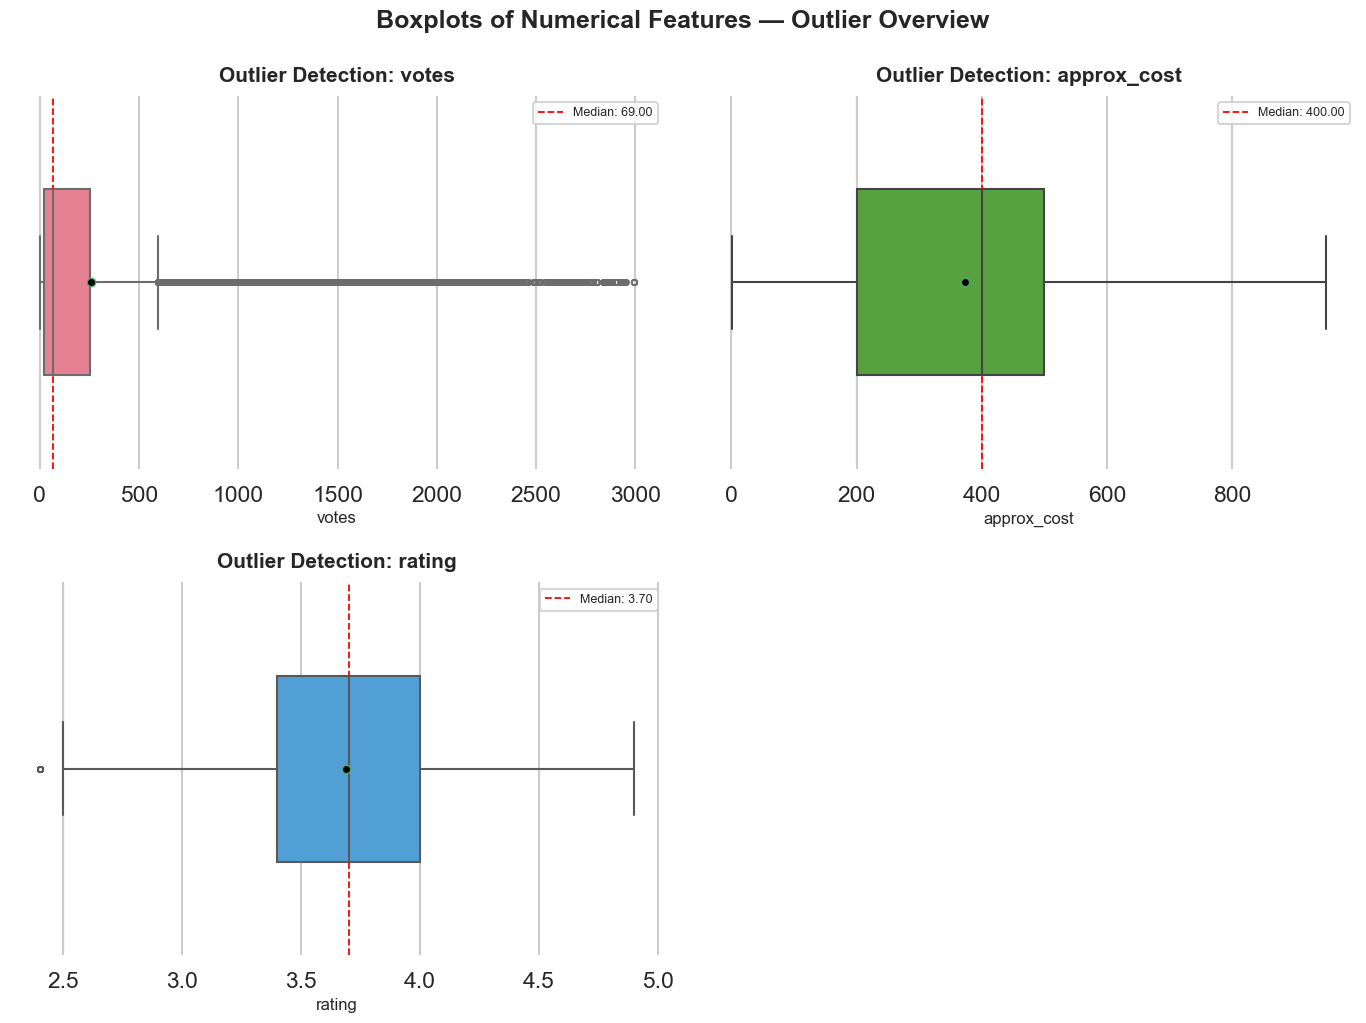

In [199]:
sns.set_theme(style="whitegrid", context="talk")

# Prepare responsive figure
plt.figure(figsize=(14, 10))
plot_num = 1
palette = sns.color_palette("husl", len(numerical_columns))  # vibrant but balanced colors

for col, color in zip(numerical_columns, palette):
    if plot_num <= 4:
        plt.subplot(2, 2, plot_num)
        
        # Create a sleek horizontal boxplot with subtle styling
        sns.boxplot(
            x=df[col],
            color=color,
            width=0.5,
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "black", "markersize": 6},
        )
        
        # Design polish
        plt.title(f"Outlier Detection: {col}", fontsize=15, weight='bold', pad=10)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("")
        
        # Add median annotation
        median = df[col].median()
        plt.axvline(median, color="red", linestyle="--", lw=1.3, label=f"Median: {median:.2f}")
        plt.legend(fontsize=9, loc="upper right", frameon=True)
        
        # Clean look
        sns.despine(left=True, bottom=True)
        
        plot_num += 1

plt.tight_layout()
plt.suptitle("Boxplots of Numerical Features — Outlier Overview", fontsize=18, weight="bold", y=1.03)
plt.savefig('../visualizations/reports/numerical_features_outliers.png', bbox_inches='tight')
plt.show()


- Clearly, Votes has Outliers on its Upper Bound

In [136]:
numerical_columns_new = ['votes','approx_cost', "rate"]
df[numerical_columns_new] = df[numerical_columns_new]
old_df_shape = df.shape
old_df_shape

(41665, 18)

In [134]:
#df.head()

### Outlier Treatmnet
- Using Z-Score method to handle outliers, 

In [138]:
# Calculate the z-scores for the specified numerical columns
z = np.abs(zscore(df[numerical_columns_new]))

# Create a new DataFrame df1 with rows where z-scores are less than 3 for all numerical columns
df1 = df[(z < 3).all(axis=1)]
new_df_shape = df1.shape
new_df_shape

(40729, 18)

#### Dataloss Calculation

In [143]:
# checking the data loss for zscore
data_loss_zscore = ((old_df_shape[0] - new_df_shape[0]) / old_df_shape[0]) * 100 # data loss in % percentage
print('Dataloss using zscore:',np.round(data_loss_zscore,2),"%")

Dataloss using zscore: 2.25 %


- 2.25%? This is bearable! We will continue our PreProcessing now

## Skewness detection & Treatment

In [174]:
## setting df1 as df for further preprocessing and 
# also selecting only the required columns for modeling
df = df1[['votes','approx_cost', "rate"]]
df.head(2)

,votes,approx_cost,rate
0,775,800,4.1
1,787,800,4.1


## Drop Irrelevant Columns->

- instead of dropping here we have already selected only required columns above

In [ ]:
## drop Irrelevant Columns-> 
# irrelevant_columns = ['url', 'address', 'name', 'phone', 'book_table',] 

# # instead of dropping here we have already selected only required columns above
# df = df.drop(columns=irrelevant_columns, axis=1)
# df.head(2)

In [161]:
# ## creating a new column "Price_Range" based on the "approx_cost" column
# df['Price_Range'] = pd.cut(df['approx_cost'], bins=[0, 500, 1000, 1500, 2000, np.inf], labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000+'])
# df.head(2)

In [175]:
df['rating'] = df['rate']
df = df.drop(columns=['rate'], axis=1)

In [176]:
df.skew()

votes          3.064601
approx_cost    0.150623
rating        -0.301479
dtype: float64

- hmm! But still, Lets Visualize it more for clarity;

In [186]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

### Visualizing Skewness

In [188]:
# Visualizing it
# plt.figure(figsize=(10,6))
# plotnum=1
# for col in numerical_columns:
#     if plotnum<=5:
#         plt.subplot(3,2,plotnum)                  # too simple plots, updating later (ChatGPT) with better visualizations
#         sns.distplot(df[col])
#         plt.xlabel(col,fontsize=12)
#     plotnum+=1
# plt.show()

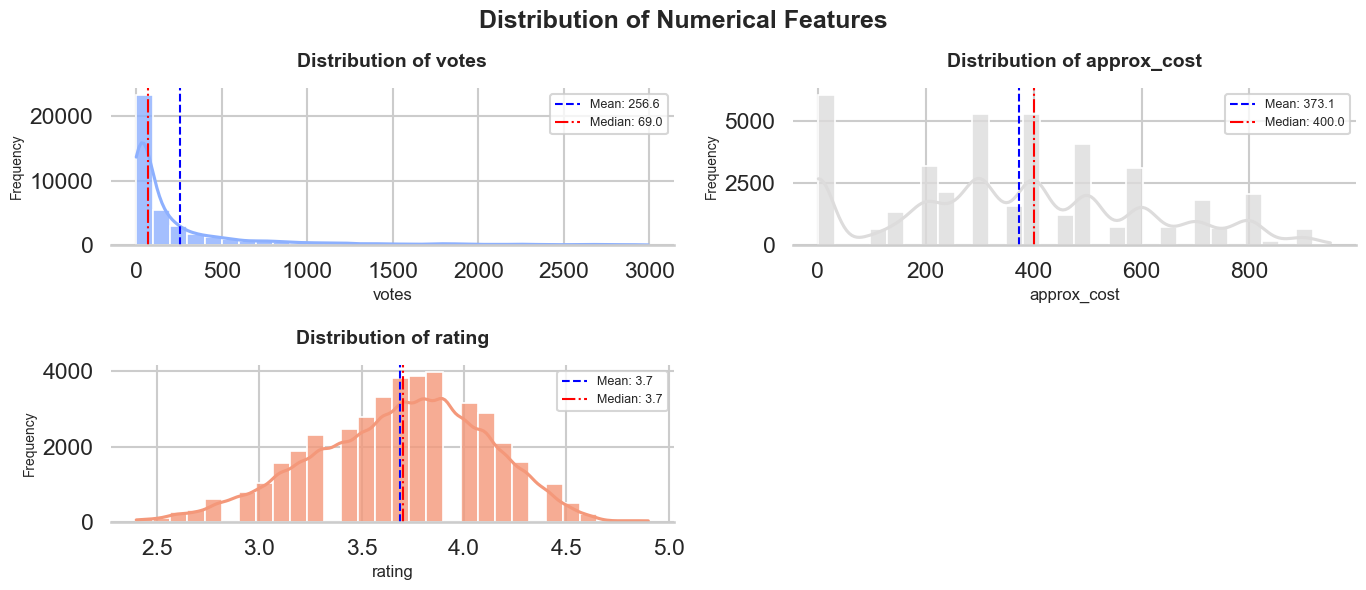

In [198]:
sns.set_theme(style="whitegrid", context="talk")

# Create figure canvas
plt.figure(figsize=(14, 8))
plotnum = 1
palette = sns.color_palette("coolwarm", len(numerical_columns))

for col, color in zip(numerical_columns, palette):
    if plotnum <= 6:  # Limit number of plots
        plt.subplot(3, 2, plotnum)
        
        # Distribution with KDE and transparency for smooth look
        sns.histplot(df[col], kde=True, color=color, bins=30, alpha=0.8, edgecolor='white', linewidth=1.2)
        
        # Add mean and median lines for interpretability
        mean_val = df[col].mean()
        median_val = df[col].median()
        plt.axvline(mean_val, color='blue', linestyle='--', lw=1.5, label=f'Mean: {mean_val:.1f}')
        plt.axvline(median_val, color='red', linestyle='-.', lw=1.5, label=f'Median: {median_val:.1f}')
        
        # Titles and labels
        plt.title(f'Distribution of {col}', fontsize=14, weight='bold', pad=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=10)
        plt.legend(frameon=True, fontsize=9, loc='upper right')
        
        sns.despine(left=True)  # Removes unnecessary borders
        
        plotnum += 1

plt.tight_layout()
plt.suptitle("Distribution of Numerical Features", fontsize=18, weight="bold", y=1.02)
plt.savefig('../visualizations/reports/numerical_features_distribution.png', bbox_inches='tight')
plt.show()



## Treating Skewness 
### Log Transformation Technique

- Machine learning algorithms don't like that imbalance because those big numbers dominate the patterns.
- So we apply a logarithmic transformation to “compress” those gigantic values

In [ ]:
# using log transformation to remove skewness from the votes
df['votes'] = np.log1p(df['votes']) # log1p is used to handle log(0) issue, making the distribution more normal


- Theory part; 

log1p is a numpy function that computes log(1 + x) for each element in the input array which is useful for data that may include zero or negative values. It helps in stabilizing variance and normalizing the distribution of data by reducing the impact of extreme values. As it adds 1 before taking the logarithm, it avoids issues with log(0) which is undefined.